In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from pathlib import Path
import os
import sys
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
parent_dir = Path(os.getcwd()).absolute()
data_dir = os.path.join(parent_dir,'baseballdatabank-master/core/')
batting_path = os.path.join(data_dir,'Batting.csv')
pitching_path = os.path.join(data_dir,'Pitching.csv')
people_path = os.path.join(data_dir,'People.csv')

In [3]:
people_df = pd.read_csv(people_path)
people_df.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,NaN,NaN,NaN,David,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,2021.0,1.0,22.0,USA,GA,Atlanta,Hank,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,USA,GA,Atlanta,Tommie,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,NaN,NaN,NaN,Don,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,NaN,NaN,NaN,Andy,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


In [4]:
batting_df = pd.read_csv(batting_path)
batting_df = batting_df[(batting_df['yearID'] > 2006) & (batting_df['yearID'] != 2020)]#batting_df.head()
batting_df.head()

pitching_df = pd.read_csv(pitching_path)
pitching_df = pitching_df[(pitching_df['yearID'] > 2006) & (pitching_df['yearID'] != 2020)]
# dropped NA pitchers because their ERA could not be calculated due to them never recording an out (14 players)
pitching_df = pitching_df.dropna()
pitching_df.head()
#batting_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
37602,aardsda01,2007,1,CHA,AL,2,1,25,0,0,0,0,97,39,23,4,17,36,0.300,6.40,3.0,2,1.0,0,151.0,7,24,2.0,1.0,1.0
37603,abreuwi01,2007,1,WAS,NL,0,1,26,0,0,0,0,91,37,20,7,9,26,0.303,5.93,1.0,2,0.0,1,133.0,3,21,1.0,1.0,5.0
37604,accarje01,2007,1,TOR,AL,4,4,64,0,0,0,30,202,51,16,4,24,57,0.206,2.14,2.0,0,2.0,1,275.0,48,19,0.0,1.0,3.0
37605,acostma01,2007,1,ATL,NL,1,1,21,0,0,0,0,71,13,6,2,14,22,0.165,2.28,1.0,1,0.0,0,93.0,5,6,0.0,0.0,5.0
37606,adkinjo01,2007,1,NYN,NL,0,0,1,0,0,0,0,3,0,0,0,0,0,0.000,0.00,0.0,0,0.0,0,3.0,0,0,0.0,0.0,0.0


In [5]:
def calc_batting_points(df):
    runs = df['R']
    singles = df['H']*2
    doubles = df['2B']*4
    triples = df['3B']*6
    home_runs = df['HR']*8
    rbi = df['RBI']*2
    steals = df['SB']*3
    caught = df['CS']*-1
    walk = df['BB'] + df['IBB'] + df['HBP']
    strike_out = df['SO']*-1
    total = runs+singles+doubles+triples+home_runs+rbi+steals+caught+walk+strike_out
    df['total_fpts'] = total
    
def calc_pitching_points(df):
    wins = df['W']*15
    loss = df['L']*-5
    cg = df['CG']*5
    so = df['SO']*5
    walk = (df['IBB']*-1) + df['HBP']
    innings = df['IPouts']/3
    total = wins+loss+cg+so+walk+innings
    df['total_fpts'] = total        

In [6]:
for row in batting_df:
    calc_batting_points(batting_df)
    
batting_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,total_fpts
88707,aardsda01,2007,1,CHA,AL,25,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88708,abercre01,2007,1,FLO,NL,35,76,16,15,3,0,2,5.0,7.0,1.0,2,22.0,0.0,2.0,0.0,0.0,1.0,86.0
88709,abreubo01,2007,1,NYA,AL,158,605,123,171,40,5,16,101.0,25.0,8.0,84,115.0,0.0,3.0,0.0,7.0,11.0,1024.0
88710,abreuto01,2007,1,LAN,NL,59,166,19,45,14,1,2,17.0,0.0,0.0,7,21.0,1.0,3.0,0.0,2.0,5.0,211.0
88711,abreuwi01,2007,1,WAS,NL,26,2,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0


In [7]:
year_list = [2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

player_pivot = pd.pivot_table(batting_df, values='total_fpts', index=['playerID'], columns=['yearID'], aggfunc=np.sum)
player_pivot = player_pivot.fillna(0)
player_pivot = player_pivot.reset_index()

def three_year_avg_pts(df):
    for year in year_list:
        last_three_years = df[[year-2,year-1,year]].reset_index(drop=True)
        three_year_list = []
        for index, row in last_three_years.iterrows():
            seasons_list = [row[year-2], row[year-1], row[year]]
            total_seasons = seasons_list.count(0)
            if total_seasons == 0:
                three_year_avg = round((row[year]+row[year-1]+row[year-2])/3,0)
            elif total_seasons == 1:
                three_year_avg = round((row[year]+row[year-1]+row[year-2])/2,0)
            elif total_seasons == 2:
                three_year_avg = round((row[year]+row[year-1]+row[year-2]),0)
            else:
                three_year_avg = 0
            three_year_list.append(three_year_avg)

        df['3yr_avg_'+str(year)] = three_year_list
    return(df.head())

three_year_avg_pts(player_pivot)

yearID,playerID,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,3yr_avg_2009,3yr_avg_2010,3yr_avg_2011,3yr_avg_2012,3yr_avg_2013,3yr_avg_2014,3yr_avg_2015,3yr_avg_2016,3yr_avg_2017,3yr_avg_2018,3yr_avg_2019
0,aardsda01,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0
1,abadfe01,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0
2,abercre01,86.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abreubo01,1024.0,1022.0,957.0,888.0,647.0,257.0,0.0,152.0,0.0,0.0,0.0,0.0,0.0,1001.0,956.0,831.0,597.0,452.0,204.0,152.0,152.0,0.0,0.0,0.0
4,abreubr01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
player_pivot_2009 = player_pivot[['playerID','3yr_avg_2009']]
player_pivot_2010 = player_pivot[['playerID','3yr_avg_2010']]
player_pivot_2011 = player_pivot[['playerID','3yr_avg_2011']]
player_pivot_2012 = player_pivot[['playerID','3yr_avg_2012']]
player_pivot_2013 = player_pivot[['playerID','3yr_avg_2013']]
player_pivot_2014 = player_pivot[['playerID','3yr_avg_2014']]
player_pivot_2015 = player_pivot[['playerID','3yr_avg_2015']]
player_pivot_2016 = player_pivot[['playerID','3yr_avg_2016']]
player_pivot_2017 = player_pivot[['playerID','3yr_avg_2017']]
player_pivot_2018 = player_pivot[['playerID','3yr_avg_2018']]
player_pivot_2019 = player_pivot[['playerID','3yr_avg_2019']]

In [9]:
for row in pitching_df:
    calc_pitching_points(pitching_df)
    
pitching_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,total_fpts
37602,aardsda01,2007,1,CHA,AL,2,1,25,0,0,0,0,97,39,23,4,17,36,0.300,6.40,3.0,2,1.0,0,151.0,7,24,2.0,1.0,1.0,235.333333
37603,abreuwi01,2007,1,WAS,NL,0,1,26,0,0,0,0,91,37,20,7,9,26,0.303,5.93,1.0,2,0.0,1,133.0,3,21,1.0,1.0,5.0,154.333333
37604,accarje01,2007,1,TOR,AL,4,4,64,0,0,0,30,202,51,16,4,24,57,0.206,2.14,2.0,0,2.0,1,275.0,48,19,0.0,1.0,3.0,392.333333
37605,acostma01,2007,1,ATL,NL,1,1,21,0,0,0,0,71,13,6,2,14,22,0.165,2.28,1.0,1,0.0,0,93.0,5,6,0.0,0.0,5.0,142.666667
37606,adkinjo01,2007,1,NYN,NL,0,0,1,0,0,0,0,3,0,0,0,0,0,0.000,0.00,0.0,0,0.0,0,3.0,0,0,0.0,0.0,0.0,1.000000


In [10]:
pitcher_pivot = pd.pivot_table(pitching_df, values='total_fpts', index=['playerID'], columns=['yearID'], aggfunc=np.sum)
pitcher_pivot = pitcher_pivot.fillna(0)
pitcher_pivot = pitcher_pivot.reset_index()

three_year_avg_pts(pitcher_pivot)

yearID,playerID,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,3yr_avg_2009,3yr_avg_2010,3yr_avg_2011,3yr_avg_2012,3yr_avg_2013,3yr_avg_2014,3yr_avg_2015,3yr_avg_2016,3yr_avg_2017,3yr_avg_2018,3yr_avg_2019
0,aardsda01,235.333333,346.666667,483.333333,261.666667,0.000000,6.0,237.666667,0.000000,213.666667,0.000000,0.000000,0.0,0.000000,355.0,364.0,372.0,134.0,122.0,122.0,226.0,214.0,214.0,0.0,0.0
1,abadfe01,0.000000,0.000000,0.000000,74.000000,90.666667,208.0,183.666667,323.333333,290.666667,235.666667,253.666667,0.0,48.000000,0.0,74.0,82.0,124.0,161.0,238.0,266.0,283.0,260.0,245.0,151.0
2,abreubr01,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,73.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0
3,abreuju01,0.000000,0.000000,0.000000,0.000000,71.666667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,72.0,72.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abreuwi01,154.333333,0.000000,37.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,96.0,37.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
pitcher_pivot_2009 = pitcher_pivot[['playerID','3yr_avg_2009']]
pitcher_pivot_2010 = pitcher_pivot[['playerID','3yr_avg_2010']]
pitcher_pivot_2011 = pitcher_pivot[['playerID','3yr_avg_2011']]
pitcher_pivot_2012 = pitcher_pivot[['playerID','3yr_avg_2012']]
pitcher_pivot_2013 = pitcher_pivot[['playerID','3yr_avg_2013']]
pitcher_pivot_2014 = pitcher_pivot[['playerID','3yr_avg_2014']]
pitcher_pivot_2015 = pitcher_pivot[['playerID','3yr_avg_2015']]
pitcher_pivot_2016 = pitcher_pivot[['playerID','3yr_avg_2016']]
pitcher_pivot_2017 = pitcher_pivot[['playerID','3yr_avg_2017']]
pitcher_pivot_2018 = pitcher_pivot[['playerID','3yr_avg_2018']]
pitcher_pivot_2019 = pitcher_pivot[['playerID','3yr_avg_2019']]

In [12]:
bat_aggregate_function = {'yearID': 'first', 'teamID': 'first', 'lgID': 'first',
                          'G': 'sum', 'AB': 'sum', 'R': 'sum', 'H': 'sum', '2B': 'sum', '3B': 'sum', 'HR': 'sum',
                          'RBI': 'sum', 'SB': 'sum', 'CS': 'sum', 'BB': 'sum', 'SO': 'sum', 'IBB': 'sum',
                          'HBP': 'sum', 'SH': 'sum', 'SF': 'sum', 'GIDP': 'sum', 'total_fpts': 'sum'}

batting_2009_df = batting_df[batting_df['yearID'] == 2009].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2010_df = batting_df[batting_df['yearID'] == 2010].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2011_df = batting_df[batting_df['yearID'] == 2011].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2012_df = batting_df[batting_df['yearID'] == 2012].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2013_df = batting_df[batting_df['yearID'] == 2013].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2014_df = batting_df[batting_df['yearID'] == 2014].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2015_df = batting_df[batting_df['yearID'] == 2015].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2016_df = batting_df[batting_df['yearID'] == 2016].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2017_df = batting_df[batting_df['yearID'] == 2017].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2018_df = batting_df[batting_df['yearID'] == 2018].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()
batting_2019_df = batting_df[batting_df['yearID'] == 2019].groupby(
    'playerID').agg(bat_aggregate_function).reset_index()

pitch_aggregate_function = {'yearID': 'first', 'stint': 'first', 'teamID': 'first', 'lgID': 'first',
                            'W': 'sum', 'L': 'sum', 'G': 'sum', 'GS': 'sum', 'CG': 'sum', 'SHO': 'sum',
                            'SV': 'sum','IPouts': 'sum', 'H': 'sum', 'ER': 'sum', 'HR': 'sum',
                            'BB': 'sum', 'SO': 'sum','BAOpp': 'sum', 'ERA': 'sum', 'IBB': 'sum', 'WP': 'sum',
                            'HBP': 'sum', 'BK': 'sum', 'BFP': 'sum', 'GF': 'sum', 'R': 'sum', 'SH': 'sum',
                            'GIDP': 'sum','total_fpts': 'sum'}

pitching_2009_df = pitching_df[pitching_df['yearID'] == 2009].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2010_df = pitching_df[pitching_df['yearID'] == 2010].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2011_df = pitching_df[pitching_df['yearID'] == 2011].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2012_df = pitching_df[pitching_df['yearID'] == 2012].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2013_df = pitching_df[pitching_df['yearID'] == 2013].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2014_df = pitching_df[pitching_df['yearID'] == 2014].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2015_df = pitching_df[pitching_df['yearID'] == 2015].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2016_df = pitching_df[pitching_df['yearID'] == 2016].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2017_df = pitching_df[pitching_df['yearID'] == 2017].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2018_df = pitching_df[pitching_df['yearID'] == 2018].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()
pitching_2019_df = pitching_df[pitching_df['yearID'] == 2019].groupby(
    'playerID').agg(pitch_aggregate_function).reset_index()

In [13]:
batting_2009_df = pd.merge(batting_2009_df,batting_2010_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2009_df = pd.merge(batting_2009_df, player_pivot_2009[['playerID','3yr_avg_2009']],on='playerID',how='left').rename(
    columns={"3yr_avg_2009": "three_year_avg"})
batting_2010_df = pd.merge(batting_2010_df,batting_2011_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2010_df = pd.merge(batting_2010_df, player_pivot_2010[['playerID','3yr_avg_2010']],on='playerID',how='left').rename(
    columns={"3yr_avg_2010": "three_year_avg"})
batting_2011_df = pd.merge(batting_2011_df,batting_2012_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2011_df = pd.merge(batting_2011_df, player_pivot_2011[['playerID','3yr_avg_2011']],on='playerID',how='left').rename(
    columns={"3yr_avg_2011": "three_year_avg"})
batting_2012_df = pd.merge(batting_2012_df,batting_2013_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2012_df = pd.merge(batting_2012_df, player_pivot_2012[['playerID','3yr_avg_2012']],on='playerID',how='left').rename(
    columns={"3yr_avg_2012": "three_year_avg"})
batting_2013_df = pd.merge(batting_2013_df,batting_2014_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2013_df = pd.merge(batting_2013_df, player_pivot_2013[['playerID','3yr_avg_2013']],on='playerID',how='left').rename(
    columns={"3yr_avg_2013": "three_year_avg"})
batting_2014_df = pd.merge(batting_2014_df,batting_2015_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2014_df = pd.merge(batting_2014_df, player_pivot_2014[['playerID','3yr_avg_2014']],on='playerID',how='left').rename(
    columns={"3yr_avg_2014": "three_year_avg"})
batting_2015_df = pd.merge(batting_2015_df,batting_2016_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2015_df = pd.merge(batting_2015_df, player_pivot_2015[['playerID','3yr_avg_2015']],on='playerID',how='left').rename(
    columns={"3yr_avg_2015": "three_year_avg"})
batting_2016_df = pd.merge(batting_2016_df,batting_2017_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2016_df = pd.merge(batting_2016_df, player_pivot_2016[['playerID','3yr_avg_2016']],on='playerID',how='left').rename(
    columns={"3yr_avg_2016": "three_year_avg"})
batting_2017_df = pd.merge(batting_2017_df,batting_2018_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2017_df = pd.merge(batting_2017_df, player_pivot_2017[['playerID','3yr_avg_2017']],on='playerID',how='left').rename(
    columns={"3yr_avg_2017": "three_year_avg"})
batting_2018_df = pd.merge(batting_2018_df,batting_2019_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
batting_2018_df = pd.merge(batting_2018_df, player_pivot_2018[['playerID','3yr_avg_2018']],on='playerID',how='left').rename(
    columns={"3yr_avg_2018": "three_year_avg"})


pitching_2009_df = pd.merge(pitching_2009_df,pitching_2010_df[['playerID','total_fpts']],on='playerID',how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2009_df = pd.merge(pitching_2009_df, pitcher_pivot_2009[['playerID','3yr_avg_2009']],on='playerID',how='left').rename(
    columns={"3yr_avg_2009": "three_year_avg"})
pitching_2010_df = pd.merge(pitching_2010_df,pitching_2011_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2010_df = pd.merge(pitching_2010_df, pitcher_pivot_2010[['playerID','3yr_avg_2010']],on='playerID',how='left').rename(
    columns={"3yr_avg_2010": "three_year_avg"})
pitching_2011_df = pd.merge(pitching_2011_df,pitching_2012_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2011_df = pd.merge(pitching_2011_df, pitcher_pivot_2011[['playerID','3yr_avg_2011']],on='playerID',how='left').rename(
    columns={"3yr_avg_2011": "three_year_avg"})
pitching_2012_df = pd.merge(pitching_2012_df,pitching_2013_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2012_df = pd.merge(pitching_2012_df, pitcher_pivot_2012[['playerID','3yr_avg_2012']],on='playerID',how='left').rename(
    columns={"3yr_avg_2012": "three_year_avg"})
pitching_2013_df = pd.merge(pitching_2013_df,pitching_2014_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2013_df = pd.merge(pitching_2013_df, pitcher_pivot_2013[['playerID','3yr_avg_2013']],on='playerID',how='left').rename(
    columns={"3yr_avg_2013": "three_year_avg"})
pitching_2014_df = pd.merge(pitching_2014_df,pitching_2015_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2014_df = pd.merge(pitching_2014_df, pitcher_pivot_2014[['playerID','3yr_avg_2014']],on='playerID',how='left').rename(
    columns={"3yr_avg_2014": "three_year_avg"})
pitching_2015_df = pd.merge(pitching_2015_df,pitching_2016_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2015_df = pd.merge(pitching_2015_df, pitcher_pivot_2015[['playerID','3yr_avg_2015']],on='playerID',how='left').rename(
    columns={"3yr_avg_2015": "three_year_avg"})
pitching_2016_df = pd.merge(pitching_2016_df,pitching_2017_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2016_df = pd.merge(pitching_2016_df, pitcher_pivot_2016[['playerID','3yr_avg_2016']],on='playerID',how='left').rename(
    columns={"3yr_avg_2016": "three_year_avg"})
pitching_2017_df = pd.merge(pitching_2017_df,pitching_2018_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2017_df = pd.merge(pitching_2017_df, pitcher_pivot_2017[['playerID','3yr_avg_2017']],on='playerID',how='left').rename(
    columns={"3yr_avg_2017": "three_year_avg"})
pitching_2018_df = pd.merge(pitching_2018_df,pitching_2019_df[['playerID','total_fpts']],on='playerID', how='left').rename(
    columns={"total_fpts_x": "total_FPTS", "total_fpts_y": "next_season_FPTS"})
pitching_2018_df = pd.merge(pitching_2018_df, pitcher_pivot_2018[['playerID','3yr_avg_2018']],on='playerID',how='left').rename(
    columns={"3yr_avg_2018": "three_year_avg"})

In [14]:
batting_dfs = [batting_2009_df, batting_2010_df, batting_2011_df, batting_2012_df, batting_2013_df, 
               batting_2014_df, batting_2015_df, batting_2016_df, batting_2017_df, batting_2018_df]

batting_df = pd.concat(batting_dfs).fillna(0)

#batting_df = pd.concat([batting_df.drop('lgID', axis=1), pd.get_dummies(batting_df['lgID'])], axis=1)

batting_df.head()
#one_hot.head()

,playerID,yearID,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,total_FPTS,next_season_FPTS,three_year_avg
0,aardsda01,2009,SEA,AL,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,abreubo01,2009,LAA,AL,152,563,96,165,29,3,15,103.0,30.0,8.0,94,113.0,7.0,1.0,0.0,9.0,15.0,957.0,888.0,1001.0
2,abreuto01,2009,LAN,NL,6,8,0,2,0,0,0,1.0,0.0,1.0,3,2.0,0.0,0.0,0.0,0.0,0.0,6.0,152.0,108.0
3,abreuwi01,2009,TBA,AL,5,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,accarje01,2009,TOR,AL,26,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
pitching_dfs = [pitching_2009_df, pitching_2010_df, pitching_2011_df, pitching_2012_df, pitching_2013_df, 
               pitching_2014_df, pitching_2015_df, pitching_2016_df, pitching_2017_df, pitching_2018_df]

pitching_df = pd.concat(pitching_dfs).fillna(0)

#pitching_df = pd.concat([pitching_df.drop('lgID', axis=1), pd.get_dummies(pitching_df['lgID'])], axis=1)

pitching_df.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,GIDP,total_FPTS,next_season_FPTS,three_year_avg
0,aardsda01,2009,1,SEA,AL,3,6,73,0,0,0,38,214,49,20,4,34,80,0.190,2.52,3.0,2,0.0,0,296.0,53,23,2.0,2.0,483.333333,261.666667,355.0
1,abreuwi01,2009,1,TBA,AL,0,0,5,0,0,0,0,18,10,7,2,4,6,0.731,25.59,0.0,0,1.0,0,32.0,1,8,0.0,1.0,37.000000,0.000000,96.0
2,accarje01,2009,1,TOR,AL,0,0,26,0,0,0,1,74,23,7,2,17,18,0.267,2.55,1.0,0,2.0,0,107.0,5,8,0.0,3.0,115.666667,17.666667,176.0
3,aceveal01,2009,1,NYA,AL,10,1,43,1,0,0,1,252,69,33,10,16,69,0.220,3.54,2.0,0,5.0,0,337.0,10,36,1.0,5.0,577.000000,67.000000,351.0
4,acostma01,2009,1,ATL,NL,1,1,36,0,0,0,0,112,45,18,4,19,32,0.300,4.34,2.0,3,2.0,0,174.0,17,19,3.0,4.0,207.333333,283.666667,191.0


In [16]:
import matplotlib.pyplot as mpl
mpl.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

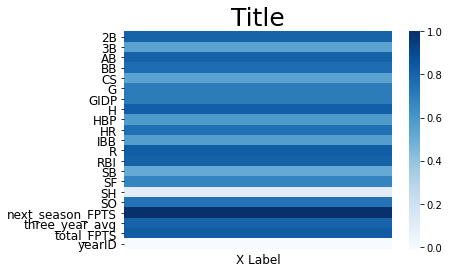

In [17]:
test = pd.DataFrame(batting_df.corrwith(batting_df["next_season_FPTS"])).sort_index()
import seaborn as sns

b = sns.heatmap(test, cmap="Blues", yticklabels=True, xticklabels=False)
b.axes.set_title("Title",fontsize=25)
b.set_xlabel("X Label",fontsize=12)
b.tick_params(labelsize=12)

In [35]:
batting_model_df = batting_df[batting_df['yearID'] != 2019]
batting_model_df = batting_model_df[['playerID','yearID','G','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO',
                                     'IBB','HBP','SH','GIDP','total_FPTS',
                                     'next_season_FPTS','three_year_avg','teamID','lgID']].reset_index(drop=True)
batting_model_df.head()

,playerID,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,GIDP,total_FPTS,next_season_FPTS,three_year_avg,teamID,lgID
0,aardsda01,2009,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,SEA,AL
1,abreubo01,2009,152,563,96,165,29,3,15,103.0,30.0,8.0,94,113.0,7.0,1.0,0.0,15.0,957.0,888.0,1001.0,LAA,AL
2,abreuto01,2009,6,8,0,2,0,0,0,1.0,0.0,1.0,3,2.0,0.0,0.0,0.0,0.0,6.0,152.0,108.0,LAN,NL
3,abreuwi01,2009,5,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,TBA,AL
4,accarje01,2009,26,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOR,AL


In [36]:
pitching_model_df = pitching_df[pitching_df['yearID'] != 2019]
pitching_model_df = pitching_model_df[['playerID','yearID','W','L','G','GS','CG','SHO','SV','IPouts','H','ER','HR',
                                     'BB','SO','BAOpp','ERA','IBB','WP','HBP','BK','BFP','GF','R','SH','GIDP',
                                     'total_FPTS', 'next_season_FPTS','three_year_avg',
                                     'teamID','lgID']].reset_index(drop=True)
pitching_model_df.head()

,playerID,yearID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,GIDP,total_FPTS,next_season_FPTS,three_year_avg,teamID,lgID
0,aardsda01,2009,3,6,73,0,0,0,38,214,49,20,4,34,80,0.190,2.52,3.0,2,0.0,0,296.0,53,23,2.0,2.0,483.333333,261.666667,355.0,SEA,AL
1,abreuwi01,2009,0,0,5,0,0,0,0,18,10,7,2,4,6,0.731,25.59,0.0,0,1.0,0,32.0,1,8,0.0,1.0,37.000000,0.000000,96.0,TBA,AL
2,accarje01,2009,0,0,26,0,0,0,1,74,23,7,2,17,18,0.267,2.55,1.0,0,2.0,0,107.0,5,8,0.0,3.0,115.666667,17.666667,176.0,TOR,AL
3,aceveal01,2009,10,1,43,1,0,0,1,252,69,33,10,16,69,0.220,3.54,2.0,0,5.0,0,337.0,10,36,1.0,5.0,577.000000,67.000000,351.0,NYA,AL
4,acostma01,2009,1,1,36,0,0,0,0,112,45,18,4,19,32,0.300,4.34,2.0,3,2.0,0,174.0,17,19,3.0,4.0,207.333333,283.666667,191.0,ATL,NL


In [38]:
batting_model_player_list = batting_model_df['playerID']
batting_model_df = batting_model_df.drop(['playerID'], axis=1)
# create dummy columns for all categorical columns
for col in batting_model_df:
    if batting_model_df[col].dtypes == "object":
        dum_df = pd.get_dummies(batting_model_df[col], columns=[col])
        batting_model_df = batting_model_df.join(dum_df)
        batting_model_df = batting_model_df.drop([col], axis=1)
    else:
        pass

batting_model_df['playerID'] = batting_model_player_list
batting_model_df.head()

,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,GIDP,total_FPTS,next_season_FPTS,three_year_avg,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,FLO,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS,AL,NL
0,2009,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,2009,152,563,96,165,29,3,15,103.0,30.0,8.0,94,113.0,7.0,1.0,0.0,15.0,957.0,888.0,1001.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2009,6,8,0,2,0,0,0,1.0,0.0,1.0,3,2.0,0.0,0.0,0.0,0.0,6.0,152.0,108.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2009,5,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,2009,26,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [39]:
batting_model_df['playerID'] = batting_model_player_list
batting_model_df

,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,GIDP,total_FPTS,next_season_FPTS,three_year_avg,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,FLO,HOU,KCA,LAA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS,AL,NL,playerID
0,2009,73,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,aardsda01
1,2009,152,563,96,165,29,3,15,103.0,30.0,8.0,94,113.0,7.0,1.0,0.0,15.0,957.0,888.0,1001.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,abreubo01
2,2009,6,8,0,2,0,0,0,1.0,0.0,1.0,3,2.0,0.0,0.0,0.0,0.0,6.0,152.0,108.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,abreuto01
3,2009,5,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,abreuwi01
4,2009,26,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,accarje01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13151,2018,34,106,14,24,5,0,2,9.0,4.0,1.0,7,44.0,0.0,1.0,0.0,1.0,91.0,-5.0,238.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,zimmebr01
13152,2018,25,2,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,-2.0,-2.0,-0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,zimmejo02
13153,2018,85,288,33,76,21,2,13,51.0,1.0,1.0,30,55.0,1.0,3.0,0.0,10.0,468.0,224.0,638.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,zimmery01
13154,2018,139,455,67,139,28,3,9,58.0,3.0,4.0,55,60.0,1.0,2.0,1.0,8.0,666.0,164.0,688.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,zobribe01


In [40]:
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()
nb_model = BayesianRidge(compute_score=True)
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 10)

model_list = [linear_model,tree_model,rf_model,nb_model,knn_model]

In [41]:
def get_scores(title,results,model,X,y,scoring,cv):
    scores = cross_validate(model,
                             X,y,
                             cv = cv,
                             scoring = scoring, return_train_score=True)
    for key,value in scores.items():
        if key == 'test_R2':
            results.append([title,key,round(value.mean(),4)])
        elif key == 'test_MSE':
            results.append([title,key,round(value.mean(),0)])

def get_grid_scores(title,results,model,X,y,scoring,cv,param_grid):

    g_cv = GridSearchCV(model,param_grid=param_grid, scoring=scoring, cv=5, refit='R2')
    g_cv.fit(X_train, y_train)
    g_cv.best_params_

    r_squared = r2_score(y_test, g_cv.best_estimator_.predict(X_test))
    mse = mean_squared_error(y_test, g_cv.best_estimator_.predict(X_test))
    
    results.append([title,'test_R2', round(r_squared,4)])
    results.append([title,'test_MSE', round(mse,0)])
    
def create_results(data):
    df = pd.DataFrame(data, columns = ['Model','Score_Type','Score'])
    df_r2 = df[df['Score_Type'] == 'test_R2']
    df_r2['key'] = df_r2['Model']
    
    df_rmse = df[df['Score_Type'] == 'test_MSE']
    df_rmse['key'] = df_rmse['Model']
    df_rmse = df_rmse[['key','Score_Type','Score']]
    
    df = df_r2.merge(df_rmse, left_on='key', right_on='key')
    df = df.rename(columns={"Score_x": "R2_Score", "Score_y": "MSE_Score"})
    df = df.drop(['Score_Type_x', 'key','Score_Type_y'], axis=1)
    df = df.sort_values(by=['R2_Score', 'MSE_Score'], ascending = False).set_index('Model')
    return df

In [47]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


X = batting_model_df.drop(['next_season_FPTS'], axis=1)
y = batting_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test = X_test.drop(['playerID','yearID'], axis=1)

# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   11.0s finished


Best Score:  0.6978171220519704
Best Params:  {'alpha': 10}


In [52]:
model_names = ['linear_model','tree_model','rf_model','nb_model','knn_model']
scoring = {'R2': make_scorer(r2_score), 'MSE': make_scorer(mean_squared_error)}


X = batting_model_df.drop(['next_season_FPTS'], axis=1)
y = batting_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test = X_test.drop(['playerID','yearID'], axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = StandardScaler().fit_transform(X_train)
pca=PCA(n_components=0.99, whiten=True)
X_train = pca.fit_transform(features)
    
# perform PCA feature reduction on test set
PCA_features_test = StandardScaler().fit_transform(X_test)
pca=PCA(n_components=0.99, whiten=True)
X_test = pca.fit_transform(PCA_features_test) 

scores = cross_validate(BayesianRidge(compute_score=True),
                             X_train,y_train,
                             cv = 5,
                             scoring = scoring, return_train_score=True)
scores

{'fit_time': array([0.04867601, 0.02073979, 0.01767612, 0.01928878, 0.01821589]),
 'score_time': array([0.0015831 , 0.00153303, 0.00142479, 0.00132918, 0.00140905]),
 'test_R2': array([0.68717486, 0.69041664, 0.69284633, 0.70336539, 0.69016549]),
 'train_R2': array([0.69931244, 0.69839676, 0.69754683, 0.69473717, 0.6980935 ]),
 'test_MSE': array([22661.79542647, 23333.02727694, 21150.81220139, 23779.7581611 ,
        20565.06113848]),
 'train_MSE': array([21879.08198013, 21722.95536909, 22272.63133047, 21613.11990356,
        22417.68099519])}

In [42]:
model_names = ['linear_model','tree_model','rf_model','nb_model','knn_model']
scoring = {'R2': make_scorer(r2_score), 'MSE': make_scorer(mean_squared_error)}


X = batting_model_df.drop(['next_season_FPTS'], axis=1)
y = batting_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test = X_test.drop(['playerID','yearID'], axis=1)
    
results = []
for x in model_names:
    if x == 'linear_model':
        title = 'Linear_Regression'
        get_scores(title,results,LinearRegression(),X_train,y_train,scoring = scoring, cv=5)
    elif x == 'tree_model':
        title = 'Decision_Tree'
        param_grid={'min_samples_split': range(2, 10)}
        get_grid_scores(title,results,DecisionTreeRegressor(),X_train,y_train,scoring = scoring, cv=5,
                        param_grid = param_grid)
    elif x == 'rf_model':
        title = 'Random_Forest'
        param_grid={'min_samples_split': range(2, 10)}
        get_grid_scores(title,results,RandomForestRegressor(),X_train,y_train,scoring = scoring, cv=5,
                        param_grid = param_grid)
    elif x == 'nb_model':
        title = 'Naive_Bayes'
        get_scores(title,results,BayesianRidge(compute_score=True),X_train,y_train,scoring = scoring, cv=5)
    elif x == 'knn_model':
        title = 'KNN'
        get_scores(title,results,neighbors.KNeighborsRegressor(n_neighbors = 10),X_train,y_train,
                   scoring = scoring, cv=5)

score_df = create_results(results)
score_df

,R2_Score,MSE_Score
Model,,
Naive_Bayes,0.6974,21968.0
Random_Forest,0.6963,22324.0
Linear_Regression,0.6958,22085.0
KNN,0.6836,22962.0
Decision_Tree,0.4700,38959.0


In [23]:
X = batting_model_df.drop(['next_season_FPTS'], axis=1)
y = batting_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train_id = X_train[['playerID','yearID']]
X_train_id['ID'] = X_train_id.index
X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test_id = X_test[['playerID','yearID']]
X_test_id['ID'] = X_test_id.index
X_test = X_test.drop(['playerID','yearID'], axis=1)

nb_model = BayesianRidge(compute_score=True)

nb_model.fit(X_train, y_train)

nb_test_preds = nb_model.predict(X_test)

X_test['NB_Pred'] = nb_test_preds

X_test['NB_Pred'] = round(X_test['NB_Pred'],0)
                     
X_test['Actual'] = y_test
X_test['ID'] = X_test.index

viewdf = pd.merge(X_test, X_test_id, on='ID')
viewdf

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,GIDP,total_FPTS,three_year_avg,NB_Pred,Actual,ID,playerID,yearID
0,34,4,1,1,0,1,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,9.0,4.0,19.0,0.0,3777,wilsocj01,2011
1,32,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,4211,fuentbr01,2012
2,52,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,0.0,563,jenksbo01,2009
3,5,11,1,5,0,0,0,1.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,10.0,4.0,40.0,74.0,4238,gimenhe01,2012
4,28,58,8,16,2,1,0,3.0,0.0,0.0,1,8.0,0.0,0.0,0.0,0.0,53.0,61.0,73.0,10.0,12860,sanchad01,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3284,3,3,1,1,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,36.0,0.0,12025,conlopj01,2018
3285,76,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-23.0,0.0,8906,stroppe01,2015
3286,131,469,56,122,19,1,10,48.0,0.0,1.0,53,58.0,1.0,4.0,3.0,13.0,557.0,557.0,453.0,728.0,7536,solarya01,2014
3287,130,470,54,132,17,6,5,48.0,7.0,2.0,23,78.0,4.0,2.0,0.0,18.0,528.0,500.0,457.0,467.0,8258,hechaad01,2015


In [24]:
batting_2019_df = pd.merge(batting_2019_df, player_pivot_2019[['playerID','3yr_avg_2019']],on='playerID',how='left').rename(
    columns={"3yr_avg_2019": "three_year_avg"})

batting_model_2019 = batting_2019_df[['playerID','yearID','G','AB','R','H','2B','3B','HR','RBI','SB','CS','BB','SO',
                                     'IBB','HBP','SH','GIDP','total_fpts','three_year_avg']]

batter_19_id = batting_model_2019[['playerID','yearID']]
batter_19_id['ID'] = batter_19_id.index
batting_model_2019 = batting_model_2019.drop(['playerID','yearID'], axis=1)

nb_pred = nb_model.predict(batting_model_2019)

batting_model_2019['NB_Pred'] = nb_pred
batting_model_2019['NB_Pred'] = round(batting_model_2019['NB_Pred'],0)
batting_model_2019

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,GIDP,total_fpts,three_year_avg,NB_Pred
0,21,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
1,7,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
2,159,634,85,180,38,1,33,123.0,2.0,2.0,36,152.0,4.0,13.0,0.0,24.0,1018.0,960.0,837.0
3,156,626,127,175,22,2,41,101.0,37.0,9.0,76,188.0,4.0,9.0,0.0,8.0,1110.0,940.0,960.0
4,10,22,1,7,1,0,0,2.0,0.0,0.0,2,8.0,0.0,0.0,0.0,0.0,17.0,6.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,23,2,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,0.0,0.0,-2.0,-1.0,16.0
1406,15,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
1407,52,171,20,44,9,0,6,27.0,0.0,0.0,17,39.0,0.0,0.0,0.0,4.0,224.0,554.0,265.0
1408,47,150,24,39,5,0,1,17.0,0.0,0.0,23,24.0,0.0,1.0,0.0,6.0,164.0,458.0,204.0


In [25]:
batting_model_2019['ID'] = batting_model_2019.index
viewdf19 = pd.merge(batting_model_2019, batter_19_id , on='ID')
viewdf19 = viewdf19[['playerID','yearID','total_fpts','three_year_avg','NB_Pred']]
viewdf19['NB_Pred'] = round(viewdf19['NB_Pred'],0)
viewdf19 = viewdf19.sort_values(by='NB_Pred', ascending=False)

projections_df = pd.merge(viewdf19,people_df[['playerID','nameFirst','nameLast']],on='playerID',how='left')

projections_df

,playerID,yearID,total_fpts,three_year_avg,NB_Pred,nameFirst,nameLast
0,bellico01,2019,1272.0,1020.0,1112.0,Cody,Bellinger
1,yelicch01,2019,1176.0,1086.0,1086.0,Christian,Yelich
2,bettsmo01,2019,1119.0,1147.0,1045.0,Mookie,Betts
3,bregmal01,2019,1223.0,1093.0,1024.0,Alex,Bregman
4,arenano01,2019,1163.0,1164.0,1023.0,Nolan,Arenado
...,...,...,...,...,...,...,...
1405,chafian01,2019,0.0,0.0,-24.0,Andrew,Chafin
1406,suerowa01,2019,-1.0,-1.0,-25.0,Wander,Suero
1407,petityu01,2019,0.0,0.0,-26.0,Yusmeiro,Petit
1408,kolarad01,2019,0.0,0.0,-27.0,Adam,Kolarek


In [26]:
projections_df = projections_df[['nameFirst','nameLast','NB_Pred','total_fpts']].rename(
    columns={"nameFirst": "First_Name", "nameLast": "Last_Name", "NB_Pred": "Projected_2021",
             "total_fpts": "FPTS_2019"})
projections_df['change'] = (projections_df['Projected_2021'] - projections_df['FPTS_2019']) / projections_df['FPTS_2019']
projections_df['percent_change'] = pd.Series(["{0:.2f}%".format(val * 100) for val in projections_df['change']], index = projections_df.index)
projections_df.head()

,First_Name,Last_Name,Projected_2021,FPTS_2019,change,percent_change
0,Cody,Bellinger,1112.0,1272.0,-0.125786,-12.58%
1,Christian,Yelich,1086.0,1176.0,-0.076531,-7.65%
2,Mookie,Betts,1045.0,1119.0,-0.066130,-6.61%
3,Alex,Bregman,1024.0,1223.0,-0.162715,-16.27%
4,Nolan,Arenado,1023.0,1163.0,-0.120378,-12.04%


In [27]:
def regression_candidate(row):
    if row['change'] <= -0.10:
        regression = 'Regression'
    elif row['change'] >= 0.10:
        regression = 'Breakout'
    else:
        regression = 'No Change'
    return regression

projections_df['Regression_Status'] = projections_df.apply(regression_candidate, axis=1)

#Top 50 Players Based on Projected Point Totals
projections_df.head(50)

,First_Name,Last_Name,Projected_2021,FPTS_2019,change,percent_change,Regression_Status
0,Cody,Bellinger,1112.0,1272.0,-0.125786,-12.58%,Regression
1,Christian,Yelich,1086.0,1176.0,-0.076531,-7.65%,No Change
2,Mookie,Betts,1045.0,1119.0,-0.066130,-6.61%,No Change
3,Alex,Bregman,1024.0,1223.0,-0.162715,-16.27%,Regression
4,Nolan,Arenado,1023.0,1163.0,-0.120378,-12.04%,Regression
5,Anthony,Rendon,1021.0,1211.0,-0.156895,-15.69%,Regression
6,Rafael,Devers,1007.0,1213.0,-0.169827,-16.98%,Regression
7,Charlie,Blackmon,1002.0,1061.0,-0.055608,-5.56%,No Change
8,Francisco,Lindor,998.0,1038.0,-0.038536,-3.85%,No Change
9,Marcus,Semien,989.0,1170.0,-0.154701,-15.47%,Regression


In [28]:
model_names = ['linear_model','tree_model','rf_model','nb_model','knn_model']
scoring = {'R2': make_scorer(r2_score), 'MSE': make_scorer(mean_squared_error)}


X = pitching_model_df.drop(['next_season_FPTS'], axis=1)
y = pitching_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test = X_test.drop(['playerID','yearID'], axis=1)
    
results = []
for x in model_names:
    if x == 'linear_model':
        title = 'Linear_Regression'
        get_scores(title,results,LinearRegression(),X_train,y_train,scoring = scoring, cv=5)
    elif x == 'tree_model':
        title = 'Decision_Tree'
        param_grid={'min_samples_split': range(2, 10)}
        get_grid_scores(title,results,DecisionTreeRegressor(),X_train,y_train,scoring = scoring, cv=5,
                        param_grid = param_grid)
    elif x == 'rf_model':
        title = 'Random_Forest'
        param_grid={'min_samples_split': range(2, 10)}
        get_grid_scores(title,results,RandomForestRegressor(),X_train,y_train,scoring = scoring, cv=5,
                        param_grid = param_grid)
    elif x == 'nb_model':
        title = 'Naive_Bayes'
        get_scores(title,results,BayesianRidge(compute_score=True),X_train,y_train,scoring = scoring, cv=5)
    elif x == 'knn_model':
        title = 'KNN'
        get_scores(title,results,neighbors.KNeighborsRegressor(n_neighbors = 10),X_train,y_train,
                   scoring = scoring, cv=5)

score_df = create_results(results)
score_df

,R2_Score,MSE_Score
Model,,
Naive_Bayes,0.5642,63746.0
Linear_Regression,0.5625,63991.0
KNN,0.5245,69512.0
Random_Forest,0.4970,75303.0
Decision_Tree,0.1452,127960.0


In [29]:
X = pitching_model_df.drop(['next_season_FPTS'], axis=1)
y = pitching_model_df['next_season_FPTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

X_train_id = X_train[['playerID','yearID']]
X_train_id['ID'] = X_train_id.index
X_train = X_train.drop(['playerID','yearID'], axis=1)
X_test_id = X_test[['playerID','yearID']]
X_test_id['ID'] = X_test_id.index
X_test = X_test.drop(['playerID','yearID'], axis=1)

nb_model = BayesianRidge(compute_score=True)

nb_model.fit(X_train, y_train)

nb_test_preds = nb_model.predict(X_test)

X_test['NB_Pred'] = nb_test_preds

X_test['NB_Pred'] = round(X_test['NB_Pred'],0)
                     
X_test['Actual'] = y_test
X_test['ID'] = X_test.index

viewdf = pd.merge(X_test, X_test_id, on='ID')
viewdf

,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,GIDP,total_FPTS,three_year_avg,NB_Pred,Actual,ID,playerID,yearID
0,6,10,24,22,2,1,0,395,170,78,19,41,86,0.310,5.33,5.0,2,3.0,2,594.0,0,88,2.0,14.0,609.666667,303.0,397.0,450.333333,4582,rusinch01,2015
1,1,2,7,4,0,0,0,76,34,17,7,11,8,0.337,6.04,2.0,2,1.0,0,117.0,1,17,1.0,7.0,69.333333,115.0,96.0,0.000000,3080,ortizra01,2013
2,0,2,15,0,0,0,0,51,21,17,6,13,16,0.296,9.00,0.0,3,0.0,1,84.0,3,17,0.0,2.0,87.000000,87.0,99.0,0.000000,6330,carroco01,2018
3,0,0,2,0,0,0,0,6,3,0,0,3,1,0.333,0.00,0.0,0,0.0,0,12.0,2,0,0.0,0.0,7.000000,9.0,104.0,1.000000,3194,schumsk01,2013
4,3,8,74,0,0,0,50,211,72,23,5,18,56,0.273,2.94,4.0,2,7.0,0,291.0,63,26,2.0,17.0,358.333333,368.0,245.0,328.333333,2928,johnsji04,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,6,1,55,0,0,0,12,244,36,22,9,30,143,0.132,2.43,0.0,0,1.0,1,306.0,14,23,1.0,1.0,882.333333,644.0,800.0,787.666667,6513,haderjo01,2018
1750,9,10,28,28,0,0,0,495,176,74,23,54,168,0.273,4.04,3.0,11,6.0,1,715.0,0,82,4.0,14.0,1093.000000,1023.0,929.0,457.333333,5291,rodonca01,2016
1751,13,9,32,32,1,0,0,614,177,73,22,46,181,0.232,3.21,2.0,5,1.0,0,820.0,0,79,5.0,9.0,1263.666667,935.0,1087.0,779.333333,3043,minormi01,2013
1752,2,5,8,8,0,0,0,118,51,26,5,18,22,0.311,5.95,0.0,0,1.0,0,183.0,0,30,0.0,6.0,155.333333,155.0,164.0,0.000000,3265,waltepj01,2013


In [30]:
pitching_2019_df = pd.merge(pitching_2019_df, pitcher_pivot_2019[['playerID','3yr_avg_2019']],on='playerID',how='left').rename(
    columns={"3yr_avg_2019": "three_year_avg"})

pitching_model_2019 = pitching_2019_df[['playerID','yearID','W','L','G','GS','CG','SHO','SV','IPouts','H','ER','HR',
                                     'BB','SO','BAOpp','ERA','IBB','WP','HBP','BK','BFP','GF','R','SH','GIDP',
                                     'total_fpts','three_year_avg']]

pitcher_19_id = pitching_model_2019[['playerID','yearID']]
pitcher_19_id['ID'] = pitcher_19_id.index
pitching_model_2019 = pitching_model_2019.drop(['playerID','yearID'], axis=1)

nb_pred = nb_model.predict(pitching_model_2019)

pitching_model_2019['NB_Pred'] = nb_pred
pitching_model_2019['NB_Pred'] = round(pitching_model_2019['NB_Pred'],0)
pitching_model_2019

,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,GIDP,total_fpts,three_year_avg,NB_Pred
0,0,2,21,0,0,0,0,39,9,6,2,3,9,0.196,4.15,0.0,1,0.0,0,49.0,1,6,0.0,3.0,48.000000,151.0,118.0
1,0,0,7,0,0,0,0,26,4,1,0,3,13,0.138,1.04,0.0,0,0.0,0,32.0,2,1,0.0,1.0,73.666667,74.0,169.0
2,3,0,23,0,0,0,0,65,15,7,1,10,18,0.200,2.91,1.0,1,3.0,2,91.0,2,8,0.0,2.0,158.666667,182.0,172.0
3,0,0,15,0,0,0,0,50,18,13,4,13,14,0.592,22.02,1.0,0,0.0,0,80.0,9,13,0.0,1.0,85.666667,86.0,79.0
4,2,2,30,2,0,0,0,96,20,14,4,16,53,0.183,12.77,0.0,4,1.0,0,130.0,3,14,0.0,3.0,318.000000,125.0,297.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,0,1,17,0,0,0,0,26,10,5,1,5,8,0.294,5.19,1.0,0,1.0,0,41.0,3,5,0.0,0.0,43.666667,74.0,101.0
825,1,2,5,3,0,0,0,68,22,12,2,11,20,0.250,4.76,0.0,2,0.0,0,99.0,0,13,0.0,1.0,127.666667,128.0,190.0
826,1,13,23,23,0,0,0,336,145,86,19,25,82,0.311,6.91,2.0,3,6.0,0,504.0,0,89,3.0,5.0,476.000000,655.0,398.0
827,0,1,15,0,0,0,0,55,28,22,2,19,18,0.337,10.80,0.0,2,0.0,0,102.0,3,22,0.0,1.0,103.333333,103.0,98.0


In [31]:
pitching_model_2019['ID'] = pitching_model_2019.index
viewdf19 = pd.merge(pitching_model_2019, pitcher_19_id , on='ID')
viewdf19 = viewdf19[['playerID','yearID','total_fpts','three_year_avg','NB_Pred']]
viewdf19['NB_Pred'] = round(viewdf19['NB_Pred'],0)
viewdf19 = viewdf19.sort_values(by='NB_Pred', ascending=False)

projections_df = pd.merge(viewdf19,people_df[['playerID','nameFirst','nameLast']],on='playerID',how='left')

projections_df

,playerID,yearID,total_fpts,three_year_avg,NB_Pred,nameFirst,nameLast
0,colege01,2019,2120.333333,1740.0,1959.0,Gerrit,Cole
1,verlaju01,2019,2024.000000,1794.0,1847.0,Justin,Verlander
2,degroja01,2019,1610.000000,1619.0,1579.0,Jacob,deGrom
3,scherma01,2019,1522.333333,1755.0,1508.0,Max,Scherzer
4,biebesh01,2019,1714.333333,1280.0,1495.0,Shane,Bieber
...,...,...,...,...,...,...,...
824,murphjr01,2019,3.000000,3.0,29.0,J. R.,Murphy
825,guerrde01,2019,0.666667,78.0,20.0,Deolis,Guerra
826,bourqja01,2019,0.666667,1.0,12.0,James,Bourque
827,hearnta01,2019,-4.666667,-5.0,-73.0,Taylor,Hearn


In [32]:
projections_df = projections_df[['nameFirst','nameLast','NB_Pred','total_fpts']].rename(
    columns={"nameFirst": "First_Name", "nameLast": "Last_Name", "NB_Pred": "Projected_2021",
             "total_fpts": "FPTS_2019"})
projections_df['change'] = (projections_df['Projected_2021'] - projections_df['FPTS_2019']) / projections_df['FPTS_2019']
projections_df['percent_change'] = pd.Series(["{0:.2f}%".format(val * 100) for val in projections_df['change']], index = projections_df.index)
projections_df.head()

,First_Name,Last_Name,Projected_2021,FPTS_2019,change,percent_change
0,Gerrit,Cole,1959.0,2120.333333,-0.076089,-7.61%
1,Justin,Verlander,1847.0,2024.000000,-0.087451,-8.75%
2,Jacob,deGrom,1579.0,1610.000000,-0.019255,-1.93%
3,Max,Scherzer,1508.0,1522.333333,-0.009415,-0.94%
4,Shane,Bieber,1495.0,1714.333333,-0.127941,-12.79%


In [33]:
projections_df['Regression_Status'] = projections_df.apply(regression_candidate, axis=1)

#Top 50 Players Based on Projected Point Totals
projections_df.head(50)

,First_Name,Last_Name,Projected_2021,FPTS_2019,change,percent_change,Regression_Status
0,Gerrit,Cole,1959.0,2120.333333,-0.076089,-7.61%,No Change
1,Justin,Verlander,1847.0,2024.000000,-0.087451,-8.75%,No Change
2,Jacob,deGrom,1579.0,1610.000000,-0.019255,-1.93%,No Change
3,Max,Scherzer,1508.0,1522.333333,-0.009415,-0.94%,No Change
4,Shane,Bieber,1495.0,1714.333333,-0.127941,-12.79%,Regression
5,Stephen,Strasburg,1489.0,1710.000000,-0.129240,-12.92%,Regression
6,Charlie,Morton,1451.0,1616.666667,-0.102474,-10.25%,Regression
7,Lance,Lynn,1408.0,1631.333333,-0.136902,-13.69%,Regression
8,Patrick,Corbin,1380.0,1573.000000,-0.122695,-12.27%,Regression
9,Jack,Flaherty,1344.0,1481.333333,-0.092709,-9.27%,No Change


In [34]:
import sklearn.utils
sklearn.utils.all_estimators(type_filter='regressor')

In [57]:
str(type(AdaBoostRegressor())).split('.')[1]

'ensemble'

In [58]:
str(type(LinearRegression())).split('.')[1]

'linear_model'

In [59]:
str(type(DecisionTreeRegressor())).split('.')[1]

'tree'

In [60]:
str(type(RandomForestRegressor())).split('.')[1]

'ensemble'

In [61]:
str(type(BayesianRidge())).split('.')[1]

'linear_model'

In [62]:
str(type(neighbors.KNeighborsRegressor())).split('.')[1]

'neighbors'

In [63]:
str(type(Ridge())).split('.')[1]

'linear_model'

In [64]:
str(type(Lasso())).split('.')[1]

'linear_model'

In [68]:
models = {'linear_model': LinearRegression(), 'tree_model': DecisionTreeRegressor(),
          'rf_model': RandomForestRegressor(), 'nbb_model': BayesianRidge(compute_score=True),
          'knn_model': neighbors.KNeighborsRegressor(n_neighbors = 10), 'ridge_model': Ridge(),
          'lasso_model': Lasso(), 'ada_model': AdaBoostRegressor()}

results = []
for key, value in models.items():
    model_type = str(type(value)).split('.')[1]
    title = key
    model = value
    param_grid={'min_samples_split': range(2, 10)}
    if  model_type == 'linear_model' or model_type == 'neighbors':
        for key, value in features.items():
            get_scores(title,results,key,model,value,y_train,scoring = scoring, cv=5)
    elif model_type == 'tree' or model_type == 'ensemble':
        for key, value in features.items():
            get_grid_scores(title,results,key,model,value,y_train,scoring = scoring, cv=5, param_grid = param_grid)
    #elif model_type == 'ensemble':
        #for key, value in features.items():
            #get_grid_scores(title,results,key,model,value,y_train,scoring = scoring, cv=5, param_grid = param_grid)
    #elif model_type == 'neighbors':
        #for key, value in features.items():
            #get_scores(title,results,key,model,value,y_train,scoring = scoring, cv=5)
            
score_df = create_results(results)
score_df

linear_model is a linear model
tree
ensemble
linear_model is a linear model
neighbors
linear_model is a linear model
linear_model is a linear model
ensemble


In [ ]:
results = []
for x in model_names:
    if x == 'linear_model':
        title = 'Linear_Regression'
        for key, value in features.items():
            get_scores(title,results,key, LinearRegression(),value,y_train,scoring = scoring, cv=5)
    elif x == 'tree_model':
        title = 'Decision_Tree'
        param_grid={'min_samples_split': range(2, 10)}
        for key, value in features.items():
            get_grid_scores(title,results,key, DecisionTreeRegressor(),value,y_train,scoring = scoring, cv=5,
                        param_grid = param_grid)
    elif x == 'rf_model':
        title = 'Random_Forest'
        param_grid={'min_samples_split': range(2, 10)}
        for key, value in features.items():
            get_grid_scores(title,results,key, RandomForestRegressor(),value,y_train,scoring = scoring, cv=5,
                            param_grid = param_grid)
    elif x == 'nb_model':
        title = 'Naive_Bayes'
        for key, value in features.items():
            get_scores(title,results,key, BayesianRidge(compute_score=True),value,y_train,scoring = scoring, cv=5)
    elif x == 'knn_model':
        title = 'KNN'
        for key, value in features.items():
            get_scores(title,results,key, neighbors.KNeighborsRegressor(n_neighbors = 10),value,y_train,
                       scoring = scoring, cv=5)
    elif x == 'ridge_model':
        title = 'Ridge_Regression'
        for key, value in features.items():
            get_scores(title,results,key, Ridge(),value,y_train,scoring = scoring, cv=5)
    elif x == 'lasso_model':
        title = 'Lasso_Regression'
        for key, value in features.items():
            get_scores(title,results,key, Lasso(),value,y_train,scoring = scoring, cv=5)    
    elif x == 'ada_model':
        title = 'AdaBoost_Regression'
        for key, value in features.items():
            get_scores(title,results,key, AdaBoostRegressor(),value,y_train,scoring = scoring, cv=5)
    
score_df = create_results(results)
score_df